# Init

In [4]:
import sys
sys.path.append('../../')
sys.path.append('../infras/cellMix/')
sys.path.append('../infras/cytof_data/')
sys.path.append('../infras/')
sys.path.append('../infras/dashboards/')
sys.path.append('../experiments/')
sys.path.append('../experiments/pipeline/')
sys.path.append('../preprocess/intra_variance/')
sys.path.append('../models/cell_proportions/')
sys.path.append('../measures/cell_proportions_measures/')
sys.path.append('../preprocess/cell_specifics/')


In [5]:
from data_factory import DataFactory
from global_utils import GlobalUtils
from cytof_cell_count_infra import CytofCellCountInfra
from cell_proportions_experiments import  CellProportionsExperiments
import exploration_cytof_plots as cytof_plots
from basic import BasicDeconv
from pp_entropy_based import PpEntropyBased
from pp_dep_de_based import  PpDepDeBased
from cell_proportions_measure import CellProportionsMeasure
from pp_clean_high_intra_var import PpCleanHighIntraVar
from pp_clean_irrelevant_proteins import PpCleanIrrelevantProteins
from pp_empty import PpEmpty
from pp_entropy_based_only_largest import PpEntropyBasedOnlyLargest
from aggregate_intra_variance import AggregateIntraVariance
from pipeline_deconv import PipelineDeconv
from deconv_py.preprocess.base import BasePreprocess as PP_base
from deconv_py.preprocess.cell_specific import CellSpecific as PP_proteins
from deconv_py.preprocess.cell_specifics.pp_svm_signature import PpSvmSignature
from deconv_py.preprocess.cell_specifics.pp_entropy_based_totel_sum import PpEntropyBasedTotelSum
from deconv_py.preprocess.cell_specifics.pp_floor_under_quantile import PpFloorUnderQuantile



from pp_keep_specific_cells  import  PpKeepSpecificCells
from pp_agg_to_specific_cells import PpAggToSpecificCells

# from deconv_py.infras.data_factory import DataFactory
from deconv_py.infras.data_loader import DataLoader
from deconv_py.models.base import Base as Models_base
from deconv_py.models.cell_proportions_models import CellProportions
from deconv_py.models.cell_specific_models import CellSpecificPerPermutation
from deconv_py.experiments.cell_specific import CellSpecificMetricsPlot
from cellMix_coordinator import CellMixCoordinator

import pandas as pd
import numpy as np
from functools import partial
import multiprocessing
from sklearn import pipeline
import itertools
from scipy.optimize import least_squares
from sklearn.metrics import mean_squared_error
from functools import partial
import mygene
from scipy.optimize import minimize
import scipy.optimize
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
import os
import pickle as pkl 
from sklearn.decomposition import PCA
from IPython.display import display, HTML



%connect_info

{
  "shell_port": 54420,
  "iopub_port": 54421,
  "stdin_port": 54422,
  "control_port": 54423,
  "hb_port": 54424,
  "ip": "127.0.0.1",
  "key": "993b782b-273d776df28973536c27df05",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-d5086f59-ff06-4b4a-b6ff-b2260f05e7ee.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


# signatures

In [3]:
full_proteins_traget = pd.DataFrame(columns=["protein","gene","source"])

## enrichment based

### proteins

In [4]:
data_factory = DataFactory()
A_all_vs,B_all_vs = data_factory.load_IBD_all_vs("Intensity",index_func=lambda x:x.split(";")[0],log2_transformation=True)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\kernel\__main__.py:2: DtypeWarning: Columns (5,6,2764,2765,2773,2774,2775,2776) have mixed types. Specify dtype option on import or set low_memory=False.
  from ipykernel import kernelapp as app


In [5]:
all_proteins_ind = pd.Index([])

In [6]:
spec_cells,agg_spec_cells = PpKeepSpecificCells(),PpAggToSpecificCells()
agg_iv,pp_irl_prot  = AggregateIntraVariance(),PpCleanIrrelevantProteins()
pp_chiv = PpCleanHighIntraVar()
pp_entropy_only_largest, pp_entropy, pp_empty,pp_dep = PpEntropyBasedOnlyLargest(), PpEntropyBased(), PpEmpty(),PpDepDeBased()
pp_svm_signature,pp_totel_sum = PpSvmSignature(),PpEntropyBasedTotelSum()
pp_floor_quantile = PpFloorUnderQuantile()

steps_few_cells = [("kepp_specific_cells",spec_cells),("cleanHighIntraVariance",pp_chiv),
                  ("AggregateIntraVariance",agg_iv),("cleen_irrelevant_proteins",pp_irl_prot),("PpDepDeBased",pp_dep)]
steps_all_cells = [("PpEmpty_cells_filt",pp_empty),("cleanHighIntraVariance",pp_chiv),
                  ("AggregateIntraVariance",agg_iv),("cleen_irrelevant_proteins",pp_irl_prot),("PpDepDeBased",pp_dep)]


_params = {"cleanHighIntraVariance__how":"std","cleanHighIntraVariance__std_trh":1,
                   "AggregateIntraVariance__how":"median","PpDepDeBased__n_of_genes":80,"PpDepDeBased__is_agg_cells":False}

In [7]:
#we dont want to remove all zeros genes in the mixtures - because thos is the problem we want to solve - so i replced B with A 
pip_all_cells = pipeline.Pipeline(steps=steps_all_cells)
pip_all_cells.set_params(**_params)
sig_all_cells = pip_all_cells.transform([A_all_vs,A_all_vs])
all_proteins_ind = all_proteins_ind.union(sig_all_cells[0].index)

C:\Users\Shenorr\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
../preprocess/cell_specifics\pp_dep_de_based.py:103: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  de_df_per_cell = de_df_per_cell.loc[high_ranked_genes]


In [8]:
#we dont want to remove all zeros genes in the mixtures - because thos is the problem we want to solve - so i replced B with A 
pip_few_cells = pipeline.Pipeline(steps=steps_few_cells)
pip_few_cells.set_params(**_params)
sig_few_cells = pip_few_cells.transform([A_all_vs,A_all_vs])
all_proteins_ind = all_proteins_ind.union(sig_few_cells[0].index)

../preprocess/cell_specifics\pp_dep_de_based.py:103: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  de_df_per_cell = de_df_per_cell.loc[high_ranked_genes]


In [9]:
all_proteins_ind = all_proteins_ind.drop_duplicates()

In [10]:
full_proteins_traget["protein"] = all_proteins_ind.map(lambda x:x[0])
full_proteins_traget["gene"] = all_proteins_ind.map(lambda x:x[1])
full_proteins_traget["source"] = "enrichment_based proteins"

### transcriptomics

In [11]:
gene_enrch_df = pd.read_excel("../data/gene_expression/gene_enrch_score_per_cell.xlsx")

#reindex from ensg_id to gene_name ang protein id : 
mg = mygene.MyGeneInfo()
ens = gene_enrch_df.ensg_id.tolist()
ginfo = mg.querymany(ens, scopes='ensembl.gene')

ensg_id_to_gene_name_mapping = {}
for g in ginfo:
    if ("query" in g.keys()) and ("symbol" in g.keys()) : 
        ensg_id_to_gene_name_mapping[g["query"]] = g["symbol"]

gene_enrch_df["ensg_id"] = gene_enrch_df["ensg_id"].map(ensg_id_to_gene_name_mapping)
gene_enrch_df = gene_enrch_df.rename(columns={"ensg_id":"Gene names"})
gene_enrch_df = gene_enrch_df.drop_duplicates(subset=["Gene names"])

gene_to_prot_mapping = {gn:mp.split(";")[0]  for gn,mp in data_factory._data_loader.get_protein_profile()[["Gene names","Majority protein IDs"]].values}

#keep only with known gene names
gene_enrch_df = gene_enrch_df[gene_enrch_df["Gene names"].isin(gene_to_prot_mapping.keys())]
gene_enrch_df["Majority protein IDs"] = gene_enrch_df["Gene names"].map(lambda x : gene_to_prot_mapping[x])

querying 1-1000...done.
querying 1001-1361...done.
Finished.
6 input query terms found no hit:
	['ENSG00000186354', 'ENSG00000183729', 'ENSG00000267697', 'ENSG00000214215', 'ENSG00000284755', 'ENS
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [12]:
group_enrch_df = gene_enrch_df.loc[gene_enrch_df["specificity_category"] == "Group enriched"]
group_enrch_df_top = group_enrch_df.nlargest(100,columns=["enhanced_score"])

cell_enrch_df = gene_enrch_df.loc[gene_enrch_df["specificity_category"] == "Tissue enriched"]
cell_enrch_df_top = cell_enrch_df.loc[cell_enrch_df.groupby(by=["enhanced_tissues"])["enhanced_score"].nlargest(10).index.get_level_values(1)]

allenrch_df_top = pd.concat([cell_enrch_df_top,group_enrch_df_top]).drop_duplicates(subset=["Majority protein IDs"])

In [13]:
_full_proteins_traget = pd.DataFrame()
_full_proteins_traget["protein"] = allenrch_df_top["Majority protein IDs"]
_full_proteins_traget["gene"] = allenrch_df_top["Gene names"]
_full_proteins_traget["source"] = "enrichment_based genes"

full_proteins_traget = full_proteins_traget.append(_full_proteins_traget)

## imputation paper - all proteins ids

In [14]:
def update_imputation_paper_summary_results(curr_df,relevent_idx,new_column) : 
    new_idx = relevent_idx.difference(curr_df.index)
    df_section_to_add = pd.DataFrame(index = new_idx,columns=curr_df.columns,data=0)
    new_df = pd.concat([curr_df,df_section_to_add])
    
    new_df[new_column] = 0
    new_df[new_column].loc[relevent_idx] = 1
    return new_df
imputation_paper_summary_results = pd.DataFrame([])

In [15]:
data_factory = DataFactory()
A_all_vs,B_all_vs = data_factory.load_IBD_all_vs("Intensity",index_func=lambda x:x.split(";")[0],log2_transformation=True)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\kernel\__main__.py:2: DtypeWarning: Columns (5,6,2764,2765,2773,2774,2775,2776) have mixed types. Specify dtype option on import or set low_memory=False.
  from ipykernel import kernelapp as app


In [16]:
relvent_data = data_factory._build_relvent_data(DataFactory.IBD_A_RELVENT_DATA_all_vs, "Intensity")

profile_data, profile_data_relvent_data= data_factory.build_cell_specific_profile(
            auto_filter_by=True, relvent_data=relvent_data,
            relvent_columns=["Majority protein IDs", "Gene names"])


mixtures, mixtures_relvent_data = data_factory.build_mixture_data(relvent_data=DataFactory.IBD_B_SIMPLE_DATA,
                                                                  intensity_type = "Intensity",
                                                                  relvent_columns=["Majority protein IDs","Gene.names"],
                                                                  auto_filter_by=True,
                                                                  log2_transformation=True)

profile_data["Majority protein IDs"] = profile_data["Majority protein IDs"] .map(lambda x:x.split(";")[0])
mixtures["Majority protein IDs"] = mixtures["Majority protein IDs"] .map(lambda x:x.split(";")[0])

profile_data = profile_data.set_index(['Majority protein IDs', 'Gene names'])
mixtures = mixtures.set_index(['Majority protein IDs', 'Gene.names'])

### from paper

In [17]:
imputed_proteins_names = ["CD123" ,"CD14"  ,"CD11c" ,"CD11a" ,"CD57"  ,"CD69"  ,"CD45ro","CD45ra","CD8"   ,"CD4"   ,"CD3"   ,"CD2"   ,"CD56"  ,"CD16"  ,"CD19"  ,"CD27"  ,"CD34"  ,"CD38"  ,"CD127" ,"CD79b" ,"CD28"  ,"CD161" ,"CD278" ,"HLA.DR"]
imputed_proteins_genes = ["IL3RA" ,"CD14"  ,"ITGAX" ,"ITGAL" ,"KLRG1" ,"CD69"  ,"PTPRC" ,"PTPRC" ,"CD8B"  ,"CD4"   ,"CD3E"  ,"CD2BP2","NCAM1" ,"FCGR3A","CD19"  ,"CD27"  ,"CD34"  ,"CD38"  ,"IL7R"  ,"CD79B" ,"CD28"  ,"KLRB1" ,"ICOS"  ,"CD74"]
imputed_proteins_umprs = ["P26951","P08571","P20702","P20701","Q96E93","Q07108","P08575","P08575","P10966","P01730","P07766","O95400","P13591","P08637","P15391","P26842","P28906","P28907","P16871","P40259","P10747","Q12918","Q9Y6W8","P04233"]

pd.DataFrame(list(zip(imputed_proteins_names,imputed_proteins_genes,imputed_proteins_umprs)),columns=["protein names","genes","uniprots"])

,protein names,genes,uniprots
0,CD123,IL3RA,P26951
1,CD14,CD14,P08571
2,CD11c,ITGAX,P20702
3,CD11a,ITGAL,P20701
4,CD57,KLRG1,Q96E93
5,CD69,CD69,Q07108
6,CD45ro,PTPRC,P08575
7,CD45ra,PTPRC,P08575
8,CD8,CD8B,P10966
9,CD4,CD4,P01730


In [18]:
all_proteins_ind = all_proteins_ind.union(pd.MultiIndex.from_tuples(list(zip(imputed_proteins_umprs,imputed_proteins_genes))))

In [19]:
_full_proteins_traget = pd.DataFrame()
_full_proteins_traget["protein"] = imputed_proteins_umprs
_full_proteins_traget["gene"] = imputed_proteins_genes
_full_proteins_traget["source"] = "surface proteins"

In [20]:
full_proteins_traget = full_proteins_traget.append(_full_proteins_traget)

### mutual

In [21]:
spaciel_proteins_ind = pd.Index([])

# spaciel_proteins_ind = spaciel_proteins_ind.union(A_all_vs.index[A_all_vs.index.map(lambda x: len([ip for ip in imputed_proteins_names if ip in str(x[0])])>0 )])
# spaciel_proteins_ind = spaciel_proteins_ind.union(A_all_vs.index[A_all_vs.index.map(lambda x: len([ip for ip in imputed_proteins_names if ip in str(x[1])])>0 )])
# spaciel_proteins_ind = spaciel_proteins_ind.union(A_all_vs.index[A_all_vs.index.map(lambda x: len([ip for ip in imputed_proteins_genes if ip in str(x[0])])>0 )])
# spaciel_proteins_ind = spaciel_proteins_ind.union(A_all_vs.index[A_all_vs.index.map(lambda x: len([ip for ip in imputed_proteins_genes if ip in str(x[1])])>0 )])
spaciel_proteins_ind = spaciel_proteins_ind.union(A_all_vs.index[A_all_vs.index.map(lambda x: len([ip for ip in imputed_proteins_umprs if ip in str(x[0])])>0 )])
# spaciel_proteins_ind = spaciel_proteins_ind.union(A_all_vs.index[A_all_vs.index.map(lambda x: len([ip for ip in imputed_proteins_umprs if ip in str(x[1])])>0 )])
spaciel_proteins_ind = spaciel_proteins_ind.drop_duplicates()
spaciel_proteins_ind

imputation_paper_summary_results = update_imputation_paper_summary_results(imputation_paper_summary_results,spaciel_proteins_ind,"mutual")

### A

In [22]:
spaciel_proteins_ind_A = pd.Index([])
# spaciel_proteins_ind_A = spaciel_proteins_ind_A.union(profile_data.index[profile_data.index.map(lambda x: len([ip for ip in imputed_proteins_names if ip in str(x[0])])>0 )])
# spaciel_proteins_ind_A = spaciel_proteins_ind_A.union(profile_data.index[profile_data.index.map(lambda x: len([ip for ip in imputed_proteins_names if ip in str(x[1])])>0 )])
# spaciel_proteins_ind_A = spaciel_proteins_ind_A.union(profile_data.index[profile_data.index.map(lambda x: len([ip for ip in imputed_proteins_genes if ip in str(x[0])])>0 )])
# spaciel_proteins_ind_A = spaciel_proteins_ind_A.union(profile_data.index[profile_data.index.map(lambda x: len([ip for ip in imputed_proteins_genes if ip in str(x[1])])>0 )])
spaciel_proteins_ind_A = spaciel_proteins_ind_A.union(profile_data.index[profile_data.index.map(lambda x: len([ip for ip in imputed_proteins_umprs if ip in str(x[0])])>0 )])
# spaciel_proteins_ind_A = spaciel_proteins_ind_A.union(profile_data.index[profile_data.index.map(lambda x: len([ip for ip in imputed_proteins_umprs if ip in str(x[1])])>0 )])
spaciel_proteins_ind_A = spaciel_proteins_ind_A.drop_duplicates()
spaciel_proteins_ind_A
imputation_paper_summary_results = update_imputation_paper_summary_results(imputation_paper_summary_results,spaciel_proteins_ind_A,"A")

### B

In [23]:
spaciel_proteins_ind_B = pd.Index([])
# spaciel_proteins_ind_B = spaciel_proteins_ind_B.union(mixtures.index[mixtures.index.map(lambda x: len([ip for ip in imputed_proteins_names if ip in str(x[0])])>0 )])
# spaciel_proteins_ind_B = spaciel_proteins_ind_B.union(mixtures.index[mixtures.index.map(lambda x: len([ip for ip in imputed_proteins_names if ip in str(x[1])])>0 )])
# spaciel_proteins_ind_B = spaciel_proteins_ind_B.union(mixtures.index[mixtures.index.map(lambda x: len([ip for ip in imputed_proteins_genes if ip in str(x[0])])>0 )])
# spaciel_proteins_ind_B = spaciel_proteins_ind_B.union(mixtures.index[mixtures.index.map(lambda x: len([ip for ip in imputed_proteins_genes if ip in str(x[1])])>0 )])
spaciel_proteins_ind_B = spaciel_proteins_ind_B.union(mixtures.index[mixtures.index.map(lambda x: len([ip for ip in imputed_proteins_umprs if ip in str(x[0])])>0 )])
# spaciel_proteins_ind_B = spaciel_proteins_ind_B.union(mixtures.index[mixtures.index.map(lambda x: len([ip for ip in imputed_proteins_umprs if ip in str(x[1])])>0 )])
spaciel_proteins_ind_B = spaciel_proteins_ind_B.drop_duplicates()
spaciel_proteins_ind_B
imputation_paper_summary_results = update_imputation_paper_summary_results(imputation_paper_summary_results,spaciel_proteins_ind_B,"B")

In [24]:

for ip in imputed_proteins_umprs : 
    if len([x for x in imputation_paper_summary_results.index if (ip in x) ]) == 0 : 
        print(ip)

P10966
P28906


In [25]:
all_ind_from_paper = imputation_paper_summary_results.copy(deep=True)
all_ind_from_paper.loc[('(P28906,CD34)'),all_ind_from_paper.columns] = ([0,0,0])
all_ind_from_paper = all_ind_from_paper.rename(columns={"mutual":"both","A" : "profile","B":"mixtures"})

## entropy based

### proteins

In [26]:
data_factory = DataFactory()
A_all_vs,B_all_vs = data_factory.load_IBD_all_vs("Intensity",index_func=lambda x:x.split(";")[0],log2_transformation=True)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\kernel\__main__.py:2: DtypeWarning: Columns (5,6,2764,2765,2773,2774,2775,2776) have mixed types. Specify dtype option on import or set low_memory=False.
  from ipykernel import kernelapp as app


In [27]:
spec_cells,agg_spec_cells = PpKeepSpecificCells(),PpAggToSpecificCells()
agg_iv,pp_irl_prot  = AggregateIntraVariance(),PpCleanIrrelevantProteins()
pp_chiv = PpCleanHighIntraVar()
pp_entropy_only_largest, pp_entropy, pp_empty,pp_dep = PpEntropyBasedOnlyLargest(), PpEntropyBased(), PpEmpty(),PpDepDeBased()
pp_svm_signature,pp_totel_sum = PpSvmSignature(),PpEntropyBasedTotelSum()
pp_floor_quantile = PpFloorUnderQuantile()

steps_few_cells = [("kepp_specific_cells",spec_cells),("cleanHighIntraVariance",pp_chiv),
                  ("AggregateIntraVariance",agg_iv),("cleen_irrelevant_proteins",pp_irl_prot),("PpEntropy",pp_entropy)]
steps_all_cells = [("PpEmpty_cells_filt",pp_empty),("cleanHighIntraVariance",pp_chiv),
                  ("AggregateIntraVariance",agg_iv),("cleen_irrelevant_proteins",pp_irl_prot),("PpEntropy",pp_entropy)]


_params = {"cleanHighIntraVariance__how":"std","cleanHighIntraVariance__std_trh":1,
                   "AggregateIntraVariance__how":"median","PpEntropy__n_genes_per_cell":10,"PpEntropy__number_of_bins":20,"PpEntropy__gene_entropy_trh":2}

#we dont want to remove all zeros genes in the mixtures - because thos is the problem we want to solve - so i replced B with A 
pip_all_cells = pipeline.Pipeline(steps=steps_all_cells)
pip_all_cells.set_params(**_params)
sig_all_cells = pip_all_cells.transform([A_all_vs,A_all_vs])
all_proteins_ind = all_proteins_ind.union(sig_all_cells[0].index)

#we dont want to remove all zeros genes in the mixtures - because thos is the problem we want to solve - so i replced B with A 
pip_few_cells = pipeline.Pipeline(steps=steps_few_cells)
pip_few_cells.set_params(**_params)
sig_few_cells = pip_few_cells.transform([A_all_vs,A_all_vs])
all_proteins_ind = all_proteins_ind.union(sig_few_cells[0].index)

all_proteins_ind = all_proteins_ind.drop_duplicates()


C:\Users\Shenorr\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


In [28]:
_full_proteins_traget = pd.DataFrame()
_full_proteins_traget["protein"] = sig_few_cells[0].index.map(lambda x:x[0])
_full_proteins_traget["gene"] = sig_few_cells[0].index.map(lambda x:x[1])
_full_proteins_traget["source"] = "entropy_based proteins"


In [29]:
full_proteins_traget = full_proteins_traget.append(_full_proteins_traget)

In [30]:
full_proteins_traget = full_proteins_traget.drop_duplicates(subset=["protein",'gene'])

### transcriptomics

In [31]:
nx_mrna_signatures_human_atlas = pd.read_csv("../notebooks/DE_gene_exprs/nx_mrna_signatures_human_atlas.csv")

In [33]:
nx_mrna_signatures_human_atlas['major_protein_id'] = nx_mrna_signatures_human_atlas["Gene names"].map(lambda x:gene_to_prot_mapping[x])
nx_mrna_signatures_human_atlas = nx_mrna_signatures_human_atlas.set_index(["major_protein_id","Gene names"])

In [34]:
spec_cells,agg_spec_cells = PpKeepSpecificCells(),PpAggToSpecificCells()
agg_iv,pp_irl_prot  = AggregateIntraVariance(),PpCleanIrrelevantProteins()
pp_chiv = PpCleanHighIntraVar()
pp_entropy_only_largest, pp_entropy, pp_empty,pp_dep = PpEntropyBasedOnlyLargest(), PpEntropyBased(), PpEmpty(),PpDepDeBased()
pp_svm_signature,pp_totel_sum = PpSvmSignature(),PpEntropyBasedTotelSum()
pp_floor_quantile = PpFloorUnderQuantile()

steps_few_cells = [("cleen_irrelevant_proteins",pp_irl_prot),("PpEntropy",pp_entropy)]
steps_all_cells = [("cleen_irrelevant_proteins",pp_irl_prot),("PpEntropy",pp_entropy)]


_params = {"PpEntropy__n_genes_per_cell":10,"PpEntropy__number_of_bins":0,"PpEntropy__gene_entropy_trh":2}

#we dont want to remove all zeros genes in the mixtures - because thos is the problem we want to solve - so i replced B with A 
pip_all_cells = pipeline.Pipeline(steps=steps_all_cells)
pip_all_cells.set_params(**_params)
sig_all_cells = pip_all_cells.transform([nx_mrna_signatures_human_atlas,nx_mrna_signatures_human_atlas])
all_proteins_ind = all_proteins_ind.union(sig_all_cells[0].index)

all_proteins_ind = all_proteins_ind.drop_duplicates()


C:\Users\Shenorr\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


In [35]:
_full_proteins_traget = pd.DataFrame()
_full_proteins_traget["protein"] = sig_all_cells[0].index.map(lambda x:x[0])
_full_proteins_traget["gene"] = sig_all_cells[0].index.map(lambda x:x[1])
_full_proteins_traget["source"] = "entropy_based_mrna"

full_proteins_traget = full_proteins_traget.append(_full_proteins_traget)

full_proteins_traget = full_proteins_traget.drop_duplicates(subset=["protein",'gene'])

# save results 

In [39]:
full_proteins_traget

,protein,gene,source
0,A4D1P6,WDR91,enrichment_based proteins
1,A7E2V4,ZSWIM8,enrichment_based proteins
2,B1ALD9,POSTN,enrichment_based proteins
3,E7ES19,THBS4,enrichment_based proteins
4,F5H7N8,OLR1,enrichment_based proteins
...,...,...,...
69,Q96DT0,LGALS12,entropy_based_mrna
71,Q9HCN6-3,GP6,entropy_based_mrna
72,Q9NRG1,PRTFDC1,entropy_based_mrna
73,Q9UPY6,WASF3,entropy_based_mrna


In [41]:
full_proteins_traget.to_csv("targeted_proteins.csv")


# proteins to cells mapping

## we are using zscore to find the most relevant cell to each protein

In [42]:
from scipy.stats import zscore
signature_zscore_of_targets_df = agg_iv.transform([A_all_vs.loc[full_proteins_traget.protein],None])[0].copy(deep=True)
signature_zscore_of_targets_df = signature_zscore_of_targets_df.T.apply(zscore).T

signature_zscore_of_targets_df_1 = signature_zscore_of_targets_df[signature_zscore_of_targets_df>1.35]
signature_zscore_of_targets_df_2 = signature_zscore_of_targets_df[signature_zscore_of_targets_df>2]



C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


In [43]:
_signature_zscore_of_targets_df_2 = signature_zscore_of_targets_df_2.dropna(how = "all")
filterd_sig_zscore = pd.concat([_signature_zscore_of_targets_df_2,signature_zscore_of_targets_df_1.loc[signature_zscore_of_targets_df_1.index.difference(_signature_zscore_of_targets_df_2.index)]]).fillna(0)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\kernel\__main__.py:24: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


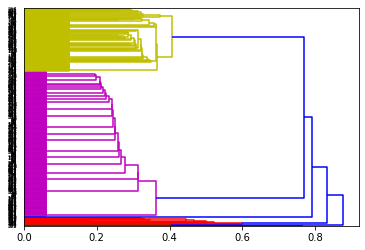

In [44]:
df_part = filterd_sig_zscore.copy(deep = True)
# D = pd.DataFrame(columns = df_part.index,index=df_part.index,data=0)
# for i,j in itertools.product(D.index,D.index) : 
#     distance = 0
#     for pn in df_part.columns : 
#         if (np.sign(df_part.loc[i][pn]) == 1) & (np.sign(df_part.loc[j][pn]) == 1) : 
#             distance += 0

#         if (np.sign(df_part.loc[i][pn]) == 0) & (np.sign(df_part.loc[j][pn]) == 0) : 
#             distance += 0

#         if (np.sign(df_part.loc[i][pn]) != np.sign(df_part.loc[j][pn])) : 
#             distance += 1

#     D.loc[i,j] = distance

from scipy.spatial.distance import pdist, squareform
import scipy.cluster.hierarchy as sch


distances = pdist(df_part, metric="hamming")
D = squareform(distances)

Y = sch.linkage(D, method='single')
Z = sch.dendrogram(Y, orientation='right')
order = Z['leaves']
plt.show()

df_part.iloc[order].to_csv("targets proteins to cell.csv")

<AxesSubplot:xlabel='cell', ylabel='major_protein_id-Gene names'>

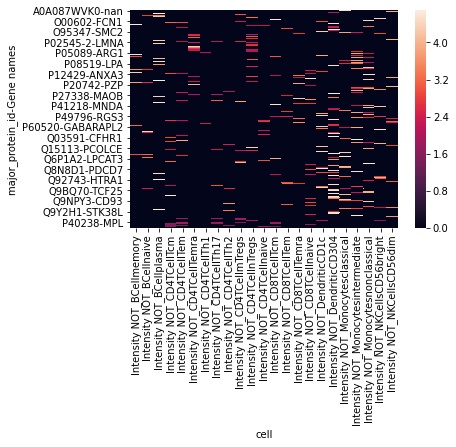

In [45]:
sns.heatmap(df_part)


In [46]:
df_part

,cell,Intensity NOT_BCellmemory,Intensity NOT_BCellnaive,Intensity NOT_BCellplasma,Intensity NOT_CD4TCellTcm,Intensity NOT_CD4TCellTem,Intensity NOT_CD4TCellTemra,Intensity NOT_CD4TCellTh1,Intensity NOT_CD4TCellTh17,Intensity NOT_CD4TCellTh2,Intensity NOT_CD4TCellmTregs,...,Intensity NOT_CD8TCellTem,Intensity NOT_CD8TCellTemra,Intensity NOT_CD8TCellnaive,Intensity NOT_DendriticCD1c,Intensity NOT_DendriticCD304,Intensity NOT_Monocytesclassical,Intensity NOT_Monocytesintermediate,Intensity NOT_Monocytesnonclassical,Intensity NOT_NKCellsCD56bright,Intensity NOT_NKCellsCD56dim
major_protein_id,Gene names,,,,,,,,,,,,,,,,,,,,,
A0A087WVK0,NaN,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,4.480235,0.000000,0.0,0.000000,0.000000
A0A087WVM2,CD177,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,3.102131,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,3.214676,0.0,0.000000,0.000000
A0A087WZR4,FCGR3B,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,3.993062
A0A0A0MS09,IGHD,3.558081,2.832814,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
A4D1P6,WDR91,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,2.086114,0.000000,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q13825,AUH,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,1.460506,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
Q8IZ07,ANKRD13A,0.000000,0.000000,0.0,1.592002,1.410864,0.0,0.0,0.000000,1.468917,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
Q99633,PRPF18;LOC101928524,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,1.668380,0.000000,0.0,...,0.000000,0.0,0.0,0.0,1.971101,0.000000,0.000000,0.0,1.427938,0.000000


# test

In [ ]:
# data_factory = DataFactory()
# A_all_vs,B_all_vs = data_factory.load_IBD_all_vs("Intensity",index_func=lambda x:x.split(";")[0],log2_transformation=True)

# B = B_all_vs.copy(deep=True)

In [ ]:
# B.index = B.index.droplevel(0)

In [ ]:
# A_tmp = pd.DataFrame(columns=A.columns,index=A.index[1:100],data=A.iloc[1:100])
# A_tmp.index = A_tmp.index.map(lambda x:f"{x}_tmp")

# B_tmp = pd.DataFrame(columns=B.columns,index=B.index[1:100],data=B.iloc[1:100])
# B_tmp.index = B_tmp.index.map(lambda x:f"{x}_tmp")

In [ ]:
# A = pd.concat([A,A_tmp])
# B = pd.concat([B,B_tmp])

In [ ]:
# B = B.loc[~B.index.duplicated(keep='first')]

In [ ]:
# B.shape

In [ ]:
# B.to_csv(r"C:\Repos\deconv_py\deconv_py\infras\xCell\B.csv")